# **Documents Filtering -- OJK Documents**

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import requests
import math

pd.set_option('display.max_colwidth', None)

from PyPDF2 import PdfReader
import fitz

## **Load Metadata**

In [26]:
df_metadata = pd.read_csv('./metadata.csv')
df_metadata.sample(3, random_state=42)

,title,page_url,sektor,subsektor,jenis_regulasi,nomor_regulasi,tanggal_berlaku,filename,file_url,new_filename
1615,Undang-Undang Republik Indonesia tentang Transfer Dana,https://www.ojk.go.id/id/regulasi/Pages/UU-Republik-Indonesia-tentang-Transfer-Dana.aspx,Perbankan,"Bank Umum, BPR, Perbankan Syariah",Undang-Undang,3 Tahun 2011,23 Maret 2011,UU-Republik-Indonesia-tentang-Transfer-Dana -- UU Nomor 3 Tahun 2011 .pdf,https://www.ojk.go.id/id/regulasi/Documents/Pages/UU-Republik-Indonesia-tentang-Transfer-Dana/UU%20Nomor%203%20Tahun%202011%20.pdf,ojk-undang_undang-3_tahun_2011-23032011-undang_undang_republik_indonesia_tentang_transfer_dana.pdf
1406,POJK tentang Rencana dan Penyelenggaraan Rapat Umum Pemegang Saham Perusahaan Terbuka,https://www.ojk.go.id/id/regulasi/Pages/POJK-tentang-Rencana-dan-Penyelenggaraan-Rapat-Umum-Pemegang-Saham-Perusahaan-Terbuka.aspx,Pasar Modal,"Pasar Modal Syariah, Bursa Efek, Perusahaan Efek, Wakil Perusahaan Efek, Lembaga Penunjang Pasar Modal, Emiten dan Perusahaan Publik",Peraturan OJK,32/POJK.04/2014,8 Desember 2014,POJK-tentang-Rencana-dan-Penyelenggaraan-Rapat-Umum-Pemegang-Saham-Perusahaan-Terbuka -- POJK 32. Rencana dan Penyelenggaraan RUPS Perusahaan Terbuka.pdf,https://www.ojk.go.id/id/regulasi/Documents/Pages/POJK-tentang-Rencana-dan-Penyelenggaraan-Rapat-Umum-Pemegang-Saham-Perusahaan-Terbuka/POJK%2032.%20Rencana%20dan%20Penyelenggaraan%20RUPS%20Perusahaan%20Terbuka.pdf,ojk-peraturan_ojk-32_pojk_04_2014-08122014-pojk_tentang_rencana_dan_penyelenggaraan_rapat_umum_pemegang_saham_perusahaan_terbuka.pdf
1906,II. F.4. Pemeriksaan Reksa Dana Berdasarkan Keputusan Ketua Badan Pengawas Pasar Modal,https://www.ojk.go.id/id/regulasi/Pages/BAPEPAM-IIF4-tentang-Pemeriksaan-Reksa-Dana.aspx,Pasar Modal,"Lembaga Penyimpanan dan Penyelesaian, Reksa Dana",Klasifikasi Bapepam,KEP-01/PM/1996,17 Januari 1996,BAPEPAM-IIF4-tentang-Pemeriksaan-Reksa-Dana -- IIF4_Pemeriksaan Reksa Dana.pdf,https://www.ojk.go.id/id/regulasi/Documents/Pages/BAPEPAM-IIF4-tentang-Pemeriksaan-Reksa-Dana/IIF4_Pemeriksaan%20Reksa%20Dana.pdf,ojk-klasifikasi_bapepam-kep_01_pm_1996-17011996-ii_f_4_pemeriksaan_reksa_dana_berdasarkan_keputusan_ketua_badan_pengawas_pasar_modal.pdf


## **Exploratory Data Analysis [ALL]**

### **Jenis Regulasi**

In [27]:
df_metadata['jenis_regulasi'].value_counts()

jenis_regulasi
Peraturan OJK                        848
Surat Edaran OJK                     606
PPBI                                 172
Klasifikasi Bapepam                  156
SEBI                                  52
Peraturan/Keputusan Mentri            46
Peraturan Bapepam                     31
Undang-Undang                         30
Peraturan Pemerintah                   9
Undang-Undang,  Peraturan OJK          1
Undang-Undang,  Peraturan Bapepam      1
Name: count, dtype: int64

### **Sektor dan Subsektor**

In [28]:
df_metadata['sektor'].value_counts()

sektor
Pasar Modal                                       622
Perbankan                                         592
IKNB                                              552
Perbankan,  Syariah                                99
EPK                                                44
Perbankan,  Pasar Modal,  IKNB,  Syariah,  EPK     12
IKNB,  Syariah                                     11
OJK                                                 6
Perbankan,  Pasar Modal,  IKNB                      5
Perbankan,  Pasar Modal,  IKNB,  Syariah            4
Perbankan,  Pasar Modal                             3
Syariah                                             2
Name: count, dtype: int64

In [29]:
sektor_subsektor_counts = {}

# Loop per baris
for _, row in df_metadata.iterrows():
    sektor = row['sektor']
    subsektors = [s.strip() for s in row['subsektor'].split(',')]
    
    if sektor not in sektor_subsektor_counts:
        sektor_subsektor_counts[sektor] = {}
    
    for subsektor in subsektors:
        if subsektor not in sektor_subsektor_counts[sektor]:
            sektor_subsektor_counts[sektor][subsektor] = 0
        sektor_subsektor_counts[sektor][subsektor] += 1

# Menampilkan hasil
for sektor, subsektor_dict in sektor_subsektor_counts.items():
    print(f"=== {sektor} ===")
    for idx, (subsektor, count) in enumerate(sorted(subsektor_dict.items()), 1):
        print(f"{idx}. {subsektor}: {count}")
    print("\n")


=== IKNB ===
1. Asuransi: 213
2. Bank Umum: 8
3. Dana Pensiun: 119
4. Dokumen Publik dan Laporan: 3
5. IKNB Syariah: 101
6. Lembaga Jasa Keuangan Khusus: 84
7. Lembaga Keuangan Mikro: 79
8. Lembaga Kliring dan Penjaminan: 22
9. Lembaga Pembiayaan: 141
10. Peraturan Lainnya: 147
11. Perbankan Syariah: 1
12. Sanksi: 3


=== Pasar Modal ===
1. Agen Penjual Reksadana: 12
2. Bank Umum: 5
3. Bursa Efek: 129
4. Dokumen Publik dan Laporan: 47
5. Emiten dan Perusahaan Publik: 136
6. Lembaga Jasa Keuangan Khusus: 2
7. Lembaga Keuangan Mikro: 2
8. Lembaga Kliring dan Penjaminan: 28
9. Lembaga Pembiayaan: 1
10. Lembaga Penunjang Pasar Modal: 45
11. Lembaga Penyimpanan dan Penyelesaian: 34
12. Pasar Modal Syariah: 52
13. Penasehat Investasi: 47
14. Peraturan Lainnya: 133
15. Perusahaan Efek: 148
16. Profesi Penunjang Pasar Modal: 26
17. Reksa Dana: 50
18. Sanksi: 3
19. Wakil Perusahaan Efek: 66


=== Perbankan ===
1. Agen Penjual Reksadana: 1
2. Asuransi: 2
3. BPR: 168
4. Bank Umum: 413
5. Bursa Ef

## **Data Preprocessing + Re-EDA [Peraturan OJK]**

### Filter Peraturan OJK

In [30]:
# Filter untuk Peraturan OJK
df_ojk = df_metadata[df_metadata['jenis_regulasi'] == 'Peraturan OJK']

### Filter Document PDF only

In [31]:
# Filter untuk file pdf saja
df_ojk = df_ojk[df_ojk['new_filename'].str.endswith('.pdf')]

### Filter Main POJK Document (Bukan Lampiran, FAQ, atau Ringkasan)

In [32]:
# 1. Ambil segmen terakhir dari setiap URL (lowercase)
last_segment = df_ojk['file_url'].str.split('/').str[-1].str.lower()

# 2. Mask untuk main POJK docs (segmen terakhir diawali 'pojk')
mask_pojk = last_segment.str.startswith('pojk')

# 3. Mask untuk mengecualikan yang mengandung '.lampiran' atau '.penjelasan'
mask_no_extras = ~last_segment.str.contains(r'\.(?:lampiran|penjelasan)', case=False, regex=True)

# 4. Cek sebelum filter tambahan
print(f"Sebelum filter: {len(df_ojk)} baris")

# 5. Terapkan kedua mask
df_ojk = df_ojk[mask_pojk & mask_no_extras].reset_index(drop=True)

# 6. Cek setelah filter dan contoh sampel
print(f"Setelah  filter: {len(df_ojk)} baris")
df_ojk.sample(5, random_state=42)

# Simpan hasil akhir
df_ojk.to_csv('./metadata_pojk_main_documents.csv', index=False)


Sebelum filter: 846 baris
Setelah  filter: 377 baris


### Cek Duplicate Kolom 'new_filename'

In [33]:
# cek duplikat pada kolom 'new_filename'
print(df_ojk['new_filename'].duplicated().sum())

# show duplicates
df_ojk[df_ojk['new_filename'].duplicated(keep=False)].sort_values('new_filename')

1


,title,page_url,sektor,subsektor,jenis_regulasi,nomor_regulasi,tanggal_berlaku,filename,file_url,new_filename
163,Transparansi dan Publikasi Laporan Bank,https://www.ojk.go.id/id/regulasi/Pages/Transparansi-dan-Publikasi-Laporan-Bank.aspx,Perbankan,Bank Umum,Peraturan OJK,37/POJK.03/2019,20 Desember 2019,Transparansi-dan-Publikasi-Laporan-Bank -- POJK 37-2019.pdf,https://www.ojk.go.id/id/regulasi/Documents/Pages/Transparansi-dan-Publikasi-Laporan-Bank/POJK%2037-2019.pdf,ojk-peraturan_ojk-37_pojk_03_2019-20122019-transparansi_dan_publikasi_laporan_bank.pdf
164,Transparansi dan Publikasi Laporan Bank,https://www.ojk.go.id/id/regulasi/Pages/Transparansi-dan-Publikasi-Laporan-Bank.aspx,Perbankan,Bank Umum,Peraturan OJK,37/POJK.03/2019,20 Desember 2019,Transparansi-dan-Publikasi-Laporan-Bank -- POJK 37-3-2019 (ENG).pdf,https://www.ojk.go.id/id/regulasi/Documents/Pages/Transparansi-dan-Publikasi-Laporan-Bank/POJK%2037-3-2019%20(ENG).pdf,ojk-peraturan_ojk-37_pojk_03_2019-20122019-transparansi_dan_publikasi_laporan_bank.pdf


In [34]:
# drop duplicates
df_ojk = df_ojk.drop_duplicates(subset=['new_filename'], keep='first').reset_index(drop=True)

### Download Main POJK Document

In [35]:
# 1. Inisialisasi path output
download_results_path = './pojk-main-documents'
os.makedirs(download_results_path, exist_ok=True)

# 2. Loop tiap baris di df_ojk (pastikan df_ojk sudah berisi kolom file_url & new_filename)
for idx, row in df_ojk.iterrows():
    url = row['file_url']
    fn  = row['new_filename']
    dest_path = os.path.join(download_results_path, fn)
    
    success = False
    for attempt in range(1, 4):  # coba hingga 3 kali
        try:
            resp = requests.get(url, stream=True, timeout=30)
            resp.raise_for_status()
            with open(dest_path, 'wb') as f:
                for chunk in resp.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
            print(f"[{idx+1}/{len(df_ojk)}] Downloaded → {fn} (attempt {attempt})")
            success = True
            break  # keluar dari retry loop setelah sukses
        except Exception as e:
            print(f"  ⚠️ Attempt {attempt} failed for {fn}: {e}")
            if attempt == 3:
                print(f"[ERROR] Gagal download {fn} setelah 3 percobaan.")
    
    # jika mau, bisa cek `if not success:` untuk tindakan tambahan

print(f"\n✅ Semua proses download selesai, cek folder: {download_results_path}/")


[1/376] Downloaded → ojk-peraturan_ojk-8_tahun_2024-05062024-produk_asuransi_dan_saluran_pemasaran_produk_asuransi.pdf (attempt 1)
[2/376] Downloaded → ojk-peraturan_ojk-6_tahun_2024-02052024-pembiayaan_transaksi_efek_oleh_perusahaan_efek_bagi_nasabah_dan_transaksi_short_selling_oleh_perusahaan_efek.pdf (attempt 1)
[3/376] Downloaded → ojk-peraturan_ojk-7_tahun_2024-30042024-bank_perekonomian_rakyat_dan_bank_perekonomian_rakyat_syariah.pdf (attempt 1)
[4/376] Downloaded → ojk-peraturan_ojk-4_tahun_2024-28022024-laporan_kepemilikan_atau_setiap_perubahan_kepemilikan_saham_perusahaan_terbuka_dan_aktivitas_menjaminkan_saham_perusahaan_terbuka.pdf (attempt 1)
[5/376] Downloaded → ojk-peraturan_ojk-3_tahun_2024-19022024-penyelenggaraan_inovasi_teknologi_sektor_keuangan.pdf (attempt 1)
[6/376] Downloaded → ojk-peraturan_ojk-2_tahun_2024-16022024-penerapan_tata_kelola_syariah_bagi_bank_umum_syariah_dan_unit_usaha_syariah.pdf (attempt 1)
[7/376] Downloaded → ojk-peraturan_ojk-1_tahun_2024-11012

### Hitung Jumlah Halaman

In [36]:
# Inisialisasi path ke folder dokumen
documents_path = './pojk-main-documents'
output_path = './metadata_pojk_main_documents_with_pages.csv'

# Fungsi untuk menghitung jumlah halaman PDF
def count_pages(pdf_path):
    try:
        reader = PdfReader(pdf_path)
        return len(reader.pages)
    except Exception as e:
        print(f"ERROR reading {pdf_path}: {e}")
        return None

# Hitung dan tambahkan kolom 'pages' menggunakan documents_path
df_ojk['pages'] = df_ojk['new_filename'].apply(
    lambda fn: count_pages(os.path.join(documents_path, fn))
)

# Simpan hasil ke CSV baru
df_ojk.to_csv(output_path, index=False)

print(f"✅ Selesai! Metadata dengan kolom 'pages' disimpan di: {output_path}")

✅ Selesai! Metadata dengan kolom 'pages' disimpan di: ./metadata_pojk_main_documents_with_pages.csv


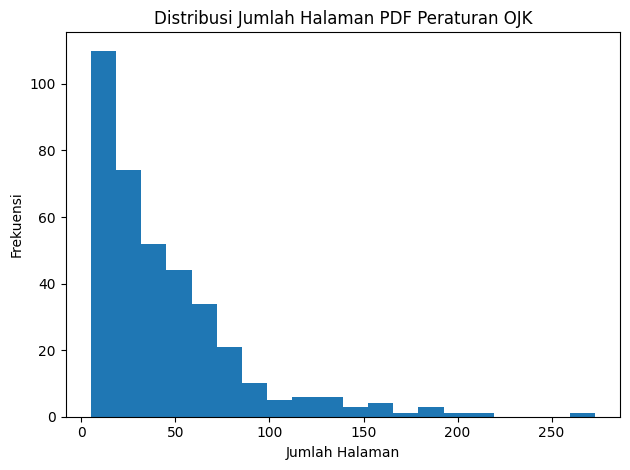

In [37]:
plt.figure()
df_ojk['pages'].plot(kind='hist', bins=20)
plt.xlabel('Jumlah Halaman')
plt.ylabel('Frekuensi')
plt.title('Distribusi Jumlah Halaman PDF Peraturan OJK')
plt.tight_layout()
plt.show()

In [38]:
# 1. Pastikan 'pages' sudah ada di df_ojk
# 2. Hitung nilai maksimum (dibulatkan ke atas jika perlu)
max_page = int(math.ceil(df_ojk['pages'].max()))

# 3. Buat bins dengan lebar 5: 0, 5, 10, ..., sampai melewati max_page
bins = list(range(0, (max_page // 5 + 2) * 5, 5))

# 4. Siapkan label: "0-5", "6-10", "11-15", dst.
labels = []
for i in range(len(bins) - 1):
    start, end = bins[i], bins[i+1]
    if i == 0:
        labels.append(f"{start}-{end}")
    else:
        labels.append(f"{start+1}-{end}")

# 5. Tambahkan kolom 'page_range' dengan interval 5 halaman
df_ojk['page_range'] = pd.cut(
    df_ojk['pages'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

# 6. Hitung frekuensi tiap rentang dan tampilkan sebagai tabel
table = (
    df_ojk['page_range']
      .value_counts(sort=False)
      .reset_index()
      .rename(columns={'index': 'Page Range', 'page_range': 'Count'})
)

print(table)

      Count  count
0       0-5      1
1      6-10     34
2     11-15     46
3     16-20     42
4     21-25     33
5     26-30     23
6     31-35     27
7     36-40     20
8     41-45     10
9     46-50     21
10    51-55     14
11    56-60     20
12    61-65     11
13    66-70     11
14    71-75     11
15    76-80      6
16    81-85      5
17    86-90      4
18    91-95      1
19   96-100      5
20  101-105      2
21  106-110      3
22  111-115      1
23  116-120      5
24  121-125      0
25  126-130      3
26  131-135      3
27  136-140      0
28  141-145      1
29  146-150      2
30  151-155      0
31  156-160      2
32  161-165      2
33  166-170      0
34  171-175      1
35  176-180      0
36  181-185      0
37  186-190      1
38  191-195      2
39  196-200      1
40  201-205      0
41  206-210      0
42  211-215      1
43  216-220      0
44  221-225      0
45  226-230      0
46  231-235      0
47  236-240      0
48  241-245      0
49  246-250      0
50  251-255      0
51  256-260 

### Filter Halaman 0-35

In [39]:
# Tentukan rentang halaman yang diinginkan
filter_range = '0-35'
min_page, max_page = map(int, filter_range.split('-'))

# Filter df_ojk berdasarkan pages
df_ojk = df_ojk[
    (df_ojk['pages'] >= min_page) &
    (df_ojk['pages'] <= max_page)
].reset_index(drop=True)

# Simpan hasil filter
df_ojk.to_csv('./metadata_pojk_main_documents_filtered.csv', index=False)

# Cetak jumlah dokumen dan contoh sampel
print(f"Jumlah dokumen dengan halaman antara {min_page}–{max_page}: {len(df_ojk)} dokumen")
print(df_ojk.sample(5, random_state=42))

Jumlah dokumen dengan halaman antara 0–35: 206 dokumen
                                                                                                                                title  \
15   Perubahan Kedua Atas Peraturan Otoritas Jasa Keuangan Nomor 11/POJK.03/2016 Tentang Kewajiban Penyediaan Modal Minimum Bank Umum   
9                  Kebijakan dalam Menjaga Kinerja dan Stabilitas Pasar Modal dalam Kondisi Pasar yang Berfluktuasi secara Signifikan   
201                                            POJK tentang Pengawasan Badan Penyelenggara Jaminan Sosial oleh Otoritas Jasa Keuangan   
82                                         Penawaran Umum Efek Bersifat Utang dan/atau Sukuk dalam Denominasi Mata Uang Selain Rupiah   
68                     Tata Cara Penyusunan Serta Pengajuan Rencana Anggaran dan Penggunaan Laba Lembaga Penyimpanan dan Penyelesaian   

                                                                                                                          

In [40]:
# copy to documents_filtered folder
# 1. Inisialisasi path
documents_path = './pojk-main-documents'
filtered_path  = './pojk-main-documents-filtered'

# 2. Buat folder tujuan jika belum ada
os.makedirs(filtered_path, exist_ok=True)

# 3. Loop dan copy tiap file
for fn in df_ojk['new_filename']:
    src = os.path.join(documents_path, fn)
    dst = os.path.join(filtered_path,  fn)
    try:
        shutil.copy2(src, dst)  # copy2 agar metadata (timestamp) ikut tersalin
        # shutil.copy(src, dst)  # bisa pakai copy() juga jika tidak butuh metadata
    except FileNotFoundError:
        print(f"⚠️ File tidak ditemukan: {src}")
    except Exception as e:
        print(f"⚠️ Gagal menyalin {src}: {e}")

print(f"\n✅ Semua file yang ada di df_ojk telah dicopy ke `{filtered_path}/`")


✅ Semua file yang ada di df_ojk telah dicopy ke `./pojk-main-documents-filtered/`


### EDA

In [41]:
# Membuat dictionary untuk sektor -> subsektor + hitungan
sektor_subsektor_counts_ojk = {}

# Loop per baris
for _, row in df_ojk.iterrows():
    sektor = row['sektor']
    subsektors = [s.strip() for s in row['subsektor'].split(',')]
    
    if sektor not in sektor_subsektor_counts_ojk:
        sektor_subsektor_counts_ojk[sektor] = {}
    
    for subsektor in subsektors:
        if subsektor not in sektor_subsektor_counts_ojk[sektor]:
            sektor_subsektor_counts_ojk[sektor][subsektor] = 0
        sektor_subsektor_counts_ojk[sektor][subsektor] += 1

# Menampilkan hasil
for sektor, subsektor_dict in sektor_subsektor_counts_ojk.items():
    print(f"=== {sektor} ===")
    for idx, (subsektor, count) in enumerate(sorted(subsektor_dict.items()), 1):
        print(f"{idx}. {subsektor}: {count}")
    print("\n")

total_subsektor_counts_ojk = sum([sum(subsektor_dict.values()) for subsektor_dict in sektor_subsektor_counts_ojk.values()])
print(f"Total subsektor counts: {total_subsektor_counts_ojk}")

=== Pasar Modal ===
1. Agen Penjual Reksadana: 2
2. Bursa Efek: 22
3. Dokumen Publik dan Laporan: 3
4. Emiten dan Perusahaan Publik: 21
5. Lembaga Kliring dan Penjaminan: 7
6. Lembaga Penunjang Pasar Modal: 11
7. Lembaga Penyimpanan dan Penyelesaian: 9
8. Pasar Modal Syariah: 15
9. Penasehat Investasi: 7
10. Peraturan Lainnya: 22
11. Perusahaan Efek: 21
12. Profesi Penunjang Pasar Modal: 6
13. Reksa Dana: 9
14. Sanksi: 2
15. Wakil Perusahaan Efek: 9


=== Perbankan ===
1. Agen Penjual Reksadana: 1
2. BPR: 13
3. Bank Umum: 29
4. Bursa Efek: 1
5. Lembaga Penunjang Pasar Modal: 1
6. Pasar Modal Syariah: 1
7. Peraturan Lainnya: 4
8. Perbankan Syariah: 14
9. Perusahaan Efek: 1
10. Profesi Penunjang Pasar Modal: 1
11. Reksa Dana: 1
12. Wakil Perusahaan Efek: 1


=== Perbankan,  Pasar Modal,  IKNB,  Syariah,  EPK ===
1. Peraturan Lainnya: 4


=== IKNB ===
1. Asuransi: 21
2. Bank Umum: 1
3. Dana Pensiun: 18
4. IKNB Syariah: 14
5. Lembaga Jasa Keuangan Khusus: 15
6. Lembaga Keuangan Mikro: 13
7

In [42]:
# df_ojk['file_url'].sample(5, random_state=42)

### Check OCR Format

In [43]:
# 1. Path ke folder dokumen POJK
documents_path = './pojk-main-documents-filtered'

# 2. Fungsi deteksi: True jika PDF **scanned** (tidak ada text layer)
def is_scanned_pdf(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        for page in doc:
            text = page.get_text().strip()
            if text:
                return False  # ada text ⇒ bukan scanned
        return True  # semua halaman tanpa text ⇒ scanned/OCR-only
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return None

# 3. Terapkan ke df_ojk (kolom 'new_filename' diasumsikan sudah ada)
df_ojk['is_scanned'] = df_ojk['new_filename'].apply(
    lambda fn: is_scanned_pdf(os.path.join(documents_path, fn))
)

# save ke CSV baru
df_ojk.to_csv('./METADATA_USED.csv', index=False)

# 4. Tampilkan ringkasan dan contoh
print("Summary (is_scanned counts):")
print(df_ojk['is_scanned'].value_counts(dropna=False))
df_ojk[['new_filename','is_scanned']].head(10)

Summary (is_scanned counts):
is_scanned
False    205
True       1
Name: count, dtype: int64


,new_filename,is_scanned
0,ojk-peraturan_ojk-6_tahun_2024-02052024-pembiayaan_transaksi_efek_oleh_perusahaan_efek_bagi_nasabah_dan_transaksi_short_selling_oleh_perusahaan_efek.pdf,False
1,ojk-peraturan_ojk-4_tahun_2024-28022024-laporan_kepemilikan_atau_setiap_perubahan_kepemilikan_saham_perusahaan_terbuka_dan_aktivitas_menjaminkan_saham_perusahaan_terbuka.pdf,False
2,ojk-peraturan_ojk-29_tahun_2023-29122023-pembelian_kembali_saham_yang_dikeluarkan_oleh_perusahaan_terbuka.pdf,False
3,ojk-peraturan_ojk-26_tahun_2023-22122023-pengguna_standar_akuntansi_keuangan_internasional_di_pasar_modal.pdf,False
4,ojk-peraturan_ojk-21_tahun_2023-22122023-layanan_digital_oleh_bank_umum.pdf,False
5,ojk-peraturan_ojk-19_tahun_2023-01112023-pengembangan_kualitas_sumber_daya_manusia_bank_perekonomian_rakyat_dan_bank_perekonomian_rakyat_syariah.pdf,False
6,ojk-peraturan_ojk-15_tahun_2023-08082023-penyelenggaraan_layanan_administrasi_prinsip_mengenali_nasabah.pdf,False
7,ojk-peraturan_ojk-16_tahun_2023-07082023-penyidikan_tindak_pidana_di_sektor_jasa_keuangan.pdf,False
8,ojk-peraturan_ojk-14_tahun_2023-02082023-perdagangan_karbon_melalui_bursa_karbon.pdf,False
9,ojk-peraturan_ojk-13_tahun_2023-20072023-kebijakan_dalam_menjaga_kinerja_dan_stabilitas_pasar_modal_dalam_kondisi_pasar_yang_berfluktuasi_secara_signifikan.pdf,False


In [2]:
import pandas as pd

df_ojk = pd.read_csv('./METADATA_USED.csv')
df_ojk.sample(5, random_state=42)

,title,page_url,sektor,subsektor,jenis_regulasi,nomor_regulasi,tanggal_berlaku,filename,file_url,new_filename,pages,page_range,is_scanned
15,Perubahan Kedua Atas Peraturan Otoritas Jasa K...,https://www.ojk.go.id/id/regulasi/Pages/Peruba...,Perbankan,Bank Umum,Peraturan OJK,27 Tahun 2022,28 Desember 2022,Perubahan-Kedua-Atas-Peraturan-Otoritas-Jasa-K...,https://www.ojk.go.id/id/regulasi/Documents/Pa...,ojk-peraturan_ojk-27_tahun_2022-28122022-perub...,15,11-15,False
9,Kebijakan dalam Menjaga Kinerja dan Stabilitas...,https://www.ojk.go.id/id/regulasi/Pages/Kebija...,Pasar Modal,Peraturan Lainnya,Peraturan OJK,13 Tahun 2023,20 Juli 2023,Kebijakan-dalam-Menjaga-Kinerja-dan-Stabilitas...,https://www.ojk.go.id/id/regulasi/Documents/Pa...,ojk-peraturan_ojk-13_tahun_2023-20072023-kebij...,16,16-20,False
201,POJK tentang Pengawasan Badan Penyelenggara Ja...,https://www.ojk.go.id/id/regulasi/Pages/POJK-t...,IKNB,"Asuransi, Dana Pensiun, Lembaga Pembiayaan, ...",Peraturan OJK,5/POJK.05/2013,31 Desember 2013,POJK-tentang-Pengawasan-Badan-Penyelenggara-Ja...,https://www.ojk.go.id/id/regulasi/Documents/Pa...,ojk-peraturan_ojk-5_pojk_05_2013-31122013-pojk...,12,11-15,False
82,Penawaran Umum Efek Bersifat Utang dan/atau Su...,https://www.ojk.go.id/id/regulasi/Pages/Penawa...,Pasar Modal,Bursa Efek,Peraturan OJK,7 /POJK.04/2020,19 Februari 2020,Penawaran-Umum-Efek-Bersifat-Utang-dan-atau-Su...,https://www.ojk.go.id/id/regulasi/Documents/Pa...,ojk-peraturan_ojk-7_pojk_04_2020-19022020-pena...,10,6-10,False
68,Tata Cara Penyusunan Serta Pengajuan Rencana A...,https://www.ojk.go.id/id/regulasi/Pages/Tata-C...,Pasar Modal,Lembaga Penyimpanan dan Penyelesaian,Peraturan OJK,22 /POJK.04/2020,23 April 2020,Tata-Cara-Penyusunan-Serta-Pengajuan-Rencana-A...,https://www.ojk.go.id/id/regulasi/Documents/Pa...,ojk-peraturan_ojk-22_pojk_04_2020-23042020-tat...,14,11-15,False
